In [1]:
%load_ext autoreload
%autoreload 2

from lcg_plus.optimizer import GBS_optimizer
from lcg_plus.cost_functions import symm_effective_squeezing_gradients, symm_effective_squeezing, state_prep_GBS, gkp_squeezing, gkp_squeezing_gradients
from lcg_plus.plotting import plot_wigner_marginals
from lcg_plus.effective_sqz import effective_sqz
from lcg_plus.conversions import dB_to_Delta, Delta_to_dB
import numpy as np
import matplotlib.pyplot as plt

## Optimising a GBS circuit

In [31]:
opt = GBS_optimizer(4,
                    pattern = [3,3,3], 
                    inf = 1e-4, 
                    bs_arrange='Clements',
                    gradients = True,
                    costf_lattice = 's',
                    costf = symm_effective_squeezing_gradients,
                   )

np.random.seed(20)

opt.set_initial_guess()
print(opt.num_params)
print(opt.init_costf)

10
(1.9367381128392216, array([ 0.03439185,  0.42471779,  1.035458  ,  0.14072109, -0.39366977,
       -0.20748336,  0.07662306, -0.05452446, -0.23624974,  0.04457244]))


In [32]:
opt.run_global_optimisation(niter = 30)
print(opt.result.fun)
print(opt.result)

basinhopping step 0: f 0.531863
basinhopping step 1: f 0.492556 trial_f 0.492556 accepted 1  lowest_f 0.492556
found new global minimum on step 1 with function value 0.492556
basinhopping step 2: f 0.531713 trial_f 0.531713 accepted 1  lowest_f 0.492556
basinhopping step 3: f 0.573752 trial_f 0.573752 accepted 1  lowest_f 0.492556
basinhopping step 4: f 0.493733 trial_f 0.493733 accepted 1  lowest_f 0.492556
basinhopping step 5: f 0.485132 trial_f 0.485132 accepted 1  lowest_f 0.485132
found new global minimum on step 5 with function value 0.485132
basinhopping step 6: f 0.717066 trial_f 0.717066 accepted 1  lowest_f 0.485132
basinhopping step 7: f 0.562184 trial_f 0.562184 accepted 1  lowest_f 0.485132
basinhopping step 8: f 1.04325 trial_f 1.04325 accepted 1  lowest_f 0.485132
basinhopping step 9: f 0.675677 trial_f 0.675677 accepted 1  lowest_f 0.485132
basinhopping step 10: f 0.532344 trial_f 0.532344 accepted 1  lowest_f 0.485132
basinhopping step 11: f 0.717317 trial_f 0.717317 a

Probability 0.00045531952916301883
Delta_x 0.6664631699959696
Delta_p 0.2498540074937109
symm Delta [dB] 5.963646541671607


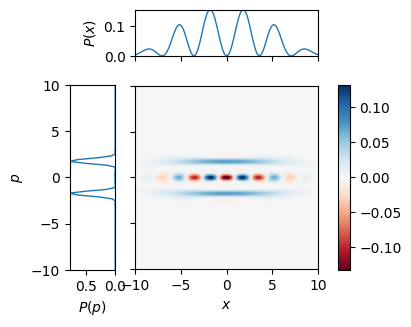

In [33]:
#Plot the output state

opt.set_initial_guess(params = opt.res_dict)
#pattern = (5,5,5)
pattern = opt.pattern

args = (opt.num_modes, 
        pattern, 
        opt.bs_arrange, 
        opt.setting, 
        opt.etas, 
        opt.nbars, 
        opt.pPNR,  
        False, #no gradients
        opt.inf,
        True) #fast rep


out = state_prep_GBS(opt.result.x, *args)
print('Probability', out.norm)
out.reduce_pure(np.sum(pattern))
Dx = effective_sqz(out, 'sx')
Dp = effective_sqz(out, 'sp')
print('Delta_x', Dx)
print('Delta_p', Dp)
print('symm Delta [dB]', Delta_to_dB(np.sqrt(0.5*(Dx**2+Dp**2))))
x = np.linspace(-10,10,100)
W = out.get_wigner_log(x,x)
plot_wigner_marginals(W.real,x,x)
plt.show()

## Other photon number patterns of optimal circuit


In [10]:
#check that the measurement probability sums to 1 of other patterns (up to a cutoff).
from itertools import product
prob = 0
cutoff = 12
patterns = list(product(range(cutoff), repeat=opt.num_modes-1))
print('pattern | prob | Delta_x | Delta_p | Delta_s')
for pattern in patterns: 
    
    args = (opt.result.x,
        opt.num_modes, 
        pattern, 
        opt.bs_arrange, 
        opt.setting, 
        opt.etas, 
        opt.nbars, 
        opt.pPNR, 
        False, #no gradients
        opt.inf, 
        True) #fast rep
    
    out = state_prep_GBS(*args)
    Delta_x=effective_sqz(out, 'sx')
    Delta_p=effective_sqz(out, 'sp')
    Delta_y = np.sqrt(0.5 * (Delta_x**2+Delta_p**2))
    if Delta_x < 0.5 or Delta_p < 0.5:
        print(pattern, out.norm, Delta_x, Delta_p, Delta_y)
    
    if out.norm > 0:
        prob += out.norm
   

print('total prob', prob) 

pattern | norm | Delta_x | Delta_p | Delta_y
(1, 3, 3) 0.0008720651260688718 0.4871679831138781 0.9309934313675073 0.742994418895825
(2, 0, 4) 0.004113993435641019 0.4659507741351464 0.7749371017946115 0.6393894101621383
(2, 0, 6) 0.00204279331071389 0.4772792926401212 1.3036345052711749 0.9816461802800119
(2, 0, 8) 0.0011521632695532054 0.47196830843276716 0.9434532334979837 0.7459417162093459
(2, 0, 10) 0.0006981844587861194 0.48056845274648213 0.7418161870677705 0.6249949172476978
(2, 2, 4) 0.000976615840805398 0.435661642020668 0.4835669063362764 0.46023799236470136
(2, 4, 2) 0.0004306800146664475 0.4340014755325481 0.49554961350658444 0.4657932482394706
(2, 6, 0) 0.00020764302753232622 0.48272774027089516 2.406504784862384 1.7355534204962682
(2, 6, 1) 9.193014982571584e-05 1.1382360130476896 0.4965730180917084 0.8781133137857006
(2, 8, 0) 5.252750575479836e-05 0.4103151772448088 0.8367936472017036 0.6590076451281002
(2, 10, 0) 1.4482030035521431e-05 0.3883574237091335 0.6938587695

## Same optimisation, but without gradients

In [37]:
opt = GBS_optimizer(4, 
                    pattern = [3,3,3], 
                    inf = 1e-4, 
                    bs_arrange='Clements',
                    costf_lattice = 's',
                    costf = symm_effective_squeezing
                   )
np.random.seed(20)
opt.set_initial_guess()
print(opt.init_costf)

1.9367381127215975


In [38]:
opt.run_global_optimisation(niter = 50)
print(opt.result.fun)
print(opt.result)

basinhopping step 0: f 0.85815
basinhopping step 1: f 0.494257 trial_f 0.494257 accepted 1  lowest_f 0.494257
found new global minimum on step 1 with function value 0.494257
basinhopping step 2: f 0.581108 trial_f 0.581108 accepted 1  lowest_f 0.494257
basinhopping step 3: f 0.940034 trial_f 0.940034 accepted 1  lowest_f 0.494257
basinhopping step 4: f 0.935766 trial_f 0.935766 accepted 1  lowest_f 0.494257
basinhopping step 5: f 0.709508 trial_f 0.709508 accepted 1  lowest_f 0.494257
basinhopping step 6: f 1.02106 trial_f 1.02106 accepted 1  lowest_f 0.494257
basinhopping step 7: f 0.711655 trial_f 0.711655 accepted 1  lowest_f 0.494257
basinhopping step 8: f 0.636972 trial_f 0.636972 accepted 1  lowest_f 0.494257
basinhopping step 9: f 0.599766 trial_f 0.599766 accepted 1  lowest_f 0.494257
basinhopping step 10: f 0.531325 trial_f 0.531325 accepted 1  lowest_f 0.494257
basinhopping step 11: f 0.494466 trial_f 0.494466 accepted 1  lowest_f 0.494257
basinhopping step 12: f 0.494466 tri

Probability 0.0006809854236540902
Delta_x 0.67479835029568
Delta_p 0.24170238553839377


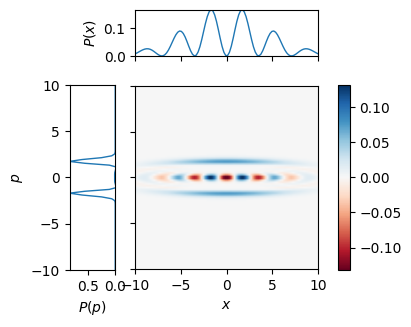

In [39]:
#Plot the output state
opt.set_initial_guess(params = opt.res_dict)

args = (opt.num_modes, 
        opt.pattern, 
        opt.bs_arrange, 
        opt.setting, 
        opt.etas, 
        opt.nbars, 
        opt.pPNR,  
        False, #no gradients
        opt.inf,
        True) #fast rep

out = state_prep_GBS(opt.result.x, *args)
print('Probability', out.norm)
out.reduce_pure(np.sum(opt.pattern))
print('Delta_x', effective_sqz(out, 'sx'))
print('Delta_p', effective_sqz(out, 'sp'))
x = np.linspace(-10,10,100)
W = out.get_wigner_log(x,x)
plot_wigner_marginals(W.real,x,x)
plt.show()